In [3]:
import matlab.engine
eng = matlab.engine.start_matlab()




In [4]:
import numpy as np;
from sklearn.neighbors import KDTree 
from FactorBP import *
from FactorBP.FactorGraph import *
from scipy.spatial import Delaunay
import scipy.io as sio
from Utils import *

def LoadHouse():
    res = np.zeros([111, 30, 2])
    for i in range(1,112):
        res[i-1] = np.loadtxt('data/cmum/house/label/house%d' %i)
    return res



def computeFeature(P1, P2, T1 ):
    res = {}
    F1 = np.zeros([T1.shape[1], 3])
    NP2 = P2.shape[0]
    F2 = np.zeros([NP2 * NP2 * NP2, 3])
    for i in xrange(T1.shape[1]):
        F1[i] = computeFeatureSimple(P1, T1[:,i])
    Fcnt = 0
    for i in xrange(NP2):
        for j in xrange(NP2):
            for k in xrange(NP2):
                F2[Fcnt] = computeFeatureSimple(P2, [i,j,k])
                Fcnt = Fcnt + 1
    res['feat1'] = F1
    res['feat2'] = F2
    
    return res

def CreateTensorHouse(P1,P2,bpermute):
    res = {}
    NP1 = P1.shape[0]
    NP2 = P2.shape[0]
    if(bpermute):
        res['GT'] = np.random.permutation(P2.shape[0])
    else:
        res['GT'] = np.array(range(P2.shape[0]))
    P1 = P1[res['GT'], :]
    
    nT = NP1 * NP2
    
    t1 = np.floor(np.random.rand(3, nT) * NP1)
    while(True):
        probFound=False;
        for i in range(3):
            ind=(t1[i,:]==t1[(i+1)%3,:])
        if(np.sum(ind)!=0):
            idxs = np.nonzero(ind)
            t1[i][idxs]=np.floor(np.random.rand(1,len(idxs))*NP1);
            probFound=True;
        if(probFound == False):
            break;
    
    tri1 = Delaunay(P1)
    tri2 = Delaunay(P2)
    t1 = tri1.simplices
    t2 = tri2.simplices
    Feature = computeFeature(P1, P2, t1)
    
    kdt = KDTree(Feature['feat2'], metric='euclidean')
    nNN = 2000;
    [dist, indices] = kdt.query(Feature['feat1'], k=nNN, return_distance=True)
    
    dist = np.exp(- (dist / np.mean(dist) ))
    
    res['Triplets'] = t1
    res['NTriplets'] = indices
    res['Similarity'] = dist
    return res


    
def ComputeFeatureDistance(F1,F2):
    res = np.zeros([F1.shape[0], F2.shape[0]])
    for i in xrange(F1.shape[0]):
        for j in xrange(F2.shape[0]):
            res[i][j] = np.linalg.norm(F1[i]-F2[j])
        
    return res


    



np.random.seed(123456)
HouseData = LoadHouse()


NofAlgorithms = 7
AlgorithmNames=['Ours', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM']
start = 0
end = 111

MeanAcc = np.zeros([10,NofAlgorithms])
MeanRtime = np.zeros([10, NofAlgorithms])
MeanObj = np.zeros([10, NofAlgorithms])

for baseline in xrange(10,101,10):



    Accuracy = np.zeros([NofAlgorithms, end - baseline])
    Rtime = np.zeros([NofAlgorithms, end - baseline])
    Obj = np.zeros([NofAlgorithms, end - baseline])




    for ImageI in range(start, end - baseline):
        res = CreateTensorHouseDelaunay(np.copy(HouseData[ImageI]), np.copy(HouseData[ImageI+baseline]), True)
        sio.savemat('Temp.mat', res)

        NofNodes = 30
        NofStates = intArray(30)
        for i in xrange(30):
            NofStates[i] = 30
        G = CFactorGraph(NofNodes, NofStates)
        for i in xrange(res['Triplets'].shape[0]):
            T = res['Triplets'][i]
            T1 = VecInt(3)
            T1[0] = int(T[0])
            T1[1] = int(T[1])
            T1[2] = int(T[2])
            NNZIs = res['NTriplets']
            NNZVs = res['Similarity'][i]
            NNZIVecs = VecVecInt(NNZIs.shape[0])
            NNZVVecs = doubleArray(NNZIs.shape[0])
            for xi in xrange(NNZIs.shape[0]):
                cNTriplets = VecInt(3)
                cNTriplets[0] = int(NNZIs[xi][0])
                cNTriplets[1] = int(NNZIs[xi][1])
                cNTriplets[2] = int(NNZIs[xi][2])
                NNZIVecs[xi] = cNTriplets
                NNZVVecs[xi] = NNZVs[xi]
            G.AddGenericGenericSparseFactor(T1, NNZIVecs, NNZVVecs)

        G.SetVerbose(False)
        #G.Solve(1000)
        G.AddAuctionFactor()
        #G.Solve(1000)
        res1 = BaBSolver(G, 50, 5, 0.005, False)
        #print(res1.Decode)
        #print(res['GT'])
        resBag = eng.runBcagm(nargout=3)
        resBagMP = eng.runBcagmQuad1(1,nargout=3)
        resBagIPFP = eng.runBcagmQuad1(2,nargout=3)
        resHGM = eng.runHGM(nargout=3)
        resRRWHM = eng.runRRWHM(nargout=3)
        resTM = eng.runTensorMatching(nargout=3)



    
        Accuracy[0][ImageI] = ComputeAccuracy(res1.Decode, res['GT'])
        Rtime[0][ImageI] = res1.Time
        Obj[0][ImageI] = res1.Value

        Accuracy[1][ImageI] = ComputeAccuracy(resBag[1][0], res['GT'])
        Rtime[1][ImageI] = resBag[0]
        Obj[1][ImageI] = resBag[2]/6

        Accuracy[2][ImageI] = ComputeAccuracy(resBagMP[1][0], res['GT'])
        Rtime[2][ImageI] = resBagMP[0]
        Obj[2][ImageI] = resBagMP[2]/6

        Accuracy[3][ImageI] = ComputeAccuracy(resBagIPFP[1][0], res['GT'])
        Rtime[3][ImageI] = resBagIPFP[0]
        Obj[3][ImageI] = resBagIPFP[2]/6

        Accuracy[4][ImageI] = ComputeAccuracy(resHGM[1][0], res['GT'])
        Rtime[4][ImageI] = resHGM[0]
        Obj[4][ImageI] = resHGM[2]/6

        Accuracy[5][ImageI] = ComputeAccuracy(resRRWHM[1][0], res['GT'])
        Rtime[5][ImageI] = resRRWHM[0]
        Obj[5][ImageI] = resRRWHM[2]/6

        Accuracy[6][ImageI] = ComputeAccuracy(resTM[1][0], res['GT'])
        Rtime[6][ImageI] = resTM[0]
        Obj[6][ImageI] = resTM[2]/6

        MaxObj = np.max(Obj[:,ImageI])
        Obj[:,ImageI] /= MaxObj

        for ai in xrange(NofAlgorithms):
            print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
                                                             Accuracy[ai][ImageI],
                                                            Rtime[ai][ImageI],
                                                            Obj[ai][ImageI]))
        print('Finished Frame: %d' %ImageI)
    

    


    for ai in xrange(NofAlgorithms):
        MeanAcc[(baseline-10)/10][ai] = np.mean(Accuracy[ai])
        MeanRtime[(baseline-10)/10][ai] = np.mean(Rtime[ai])
        MeanObj[(baseline-10)/10][ai] = np.mean(Obj[ai])
        print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
                                                        np.mean(Accuracy[ai]),
                                                        np.mean(Rtime[ai]),
                                                        np.mean(Obj[ai])))
    
    

ABBP Accuracy 1.000000 Running Time 0.001626 Obj 1.000000
BCA Accuracy 1.000000 Running Time 0.092260 Obj 1.000000
BCA-MP Accuracy 1.000000 Running Time 0.169140 Obj 1.000000
BCA-IPFP Accuracy 1.000000 Running Time 0.085222 Obj 1.000000
HGM Accuracy 0.833333 Running Time 0.022526 Obj 0.628513
RRWHM Accuracy 1.000000 Running Time 0.086752 Obj 1.000000
TM Accuracy 0.300000 Running Time 0.118029 Obj 0.203338
Finished Frame: 0
ABBP Accuracy 1.000000 Running Time 0.000548 Obj 1.000000
BCA Accuracy 1.000000 Running Time 0.020870 Obj 1.000000
BCA-MP Accuracy 1.000000 Running Time 0.104254 Obj 1.000000
BCA-IPFP Accuracy 1.000000 Running Time 0.183983 Obj 1.000000
HGM Accuracy 0.833333 Running Time 0.006085 Obj 0.631534
RRWHM Accuracy 1.000000 Running Time 0.012505 Obj 1.000000
TM Accuracy 0.200000 Running Time 0.045239 Obj 0.091433
Finished Frame: 1
ABBP Accuracy 1.000000 Running Time 0.000424 Obj 1.000000
BCA Accuracy 1.000000 Running Time 0.040126 Obj 1.000000
BCA-MP Accuracy 1.000000 Runnin

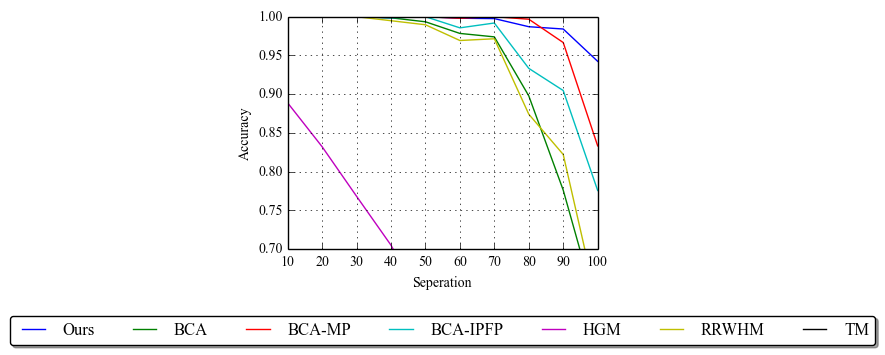

In [42]:
import matplotlib.pyplot as plt
import matplotlib
AlgorithmNames=['Ours', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM']
matplotlib.rc('font',family='Times New Roman')

%matplotlib inline

plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')

for ai in xrange(NofAlgorithms):
    plt.plot(range(10,101,10), MeanAcc[:,ai], label=AlgorithmNames[ai])
plt.ylim([0.7,1])
plt.grid(True)

plt.ylabel('Accuracy')
plt.xlabel('Seperation')

plt.legend(shadow=True, fancybox=True,loc='upper center', bbox_to_anchor=(0.5,-0.25), ncol=7)
plt.savefig('House_ACC.pdf')    # <-- loses transparency


In [19]:
StoreForPlot ={}
StoreForPlot['Accuracy'] = MeanAcc
StoreForPlot['Time'] = MeanRtime
StoreForPlot['Obj'] = MeanObj

sio.savemat('PlotData.mat', StoreForPlot)

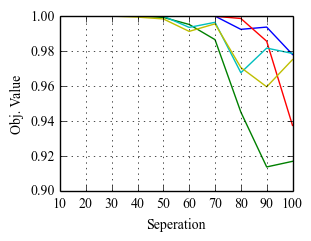

In [41]:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

%matplotlib inline
plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    plt.plot(range(10,101,10), MeanObj[:,ai], label=AlgorithmNames[ai])
plt.ylim([0.9,1])
plt.ylabel('Obj. Value')
plt.xlabel('Seperation')
plt.grid(True)
plt.savefig('House_Obj.pdf')    # <-- loses transparency


#plt.legend(shadow=True, fancybox=True,loc='upper center', bbox_to_anchor=(0.5,-0.15), ncol=7)

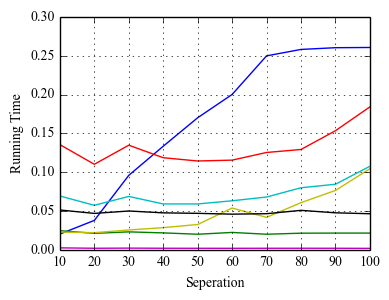

In [40]:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    plt.plot(range(10,101,10), MeanRtime[:,ai], label=AlgorithmNames[ai])
plt.ylabel('Running Time')
plt.xlabel('Seperation')

plt.grid(True)
plt.savefig('House_Time.pdf')    # <-- loses transparency